In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np

## Ссылки:
* [Chris Olah's blog (LSTM/GRU)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [PyTorch tutorial - RNN for name classification](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)
* [MNIST classification with RNN tutorial](https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79)
* [Good tutorials about Torch sentiment](https://github.com/bentrevett/pytorch-sentiment-analysis)

## Vanilla RNN

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" width="600">

$$\Large h_{i+1} = tanh(W_x \cdot X_{i+1} + W_y \cdot h_{i})$$

Рекурретные нейросети нужны для работы с **последовательными данными** произвольной длины. Они представляют собой абстрактные ячейки, у которых есть какая-то **память** (hidden state), которая обновляется после обработки очередной порции данных.

Если в самом простом виде, то в рекуррентных сетках для одного входного вектора $x_{(t)}$ и одного слоя рекуррентной сети справедливо такое соотношение:

$$y_{(t)} = \phi (x_{(t)}^T \cdot w_x + y_{(t-1)}^T \cdot w_y + b)$$

где 
* $x(t)$ — входной вектор на текущем шаге;
* $y(t)$ — выходной вектор на текущем шаге;
* $w_x$ — вектор весов нейронов для входа;
* $w_y$ — вектор весов нейронов для выхода;
* $y(t-1)$ — выходной вектор с прошлого шага (для первого шага этот вектор нулевой);
* $b$ — bias;
* $\phi$ — какая-то функция активации (например, ReLU).

Эту ячейку применяют по очереди ко всей последовательности, пробрасывая hidden state с предыдущего состояния. С точки зрения построения вычислительного графа это выглядит так:

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" width="600">

То есть если зафиксировать длину последовательности, то мы получим обычный фиксированный ациклический граф вычислений, в котором просто пошерены параметры всех ячеек.

### Упрощение формулы

Снова немножко математики чтобы привести формулу выше к более удобному виду.

Представим, что на вход подается не один вектор $x_{(t)}$, а целый мини-батч размера $m$ таких векторов $X_{(t)}$, соответственно все дальнейшие размышления мы уже производим в матричном виде:

$$ Y_{(t)} = \phi(X_{(t)}^T \cdot W_x + Y_{(t-1)}^T \cdot W_y + b) = \phi([X_{(t)} Y_{(t-1)}] \cdot W + b) $$
где
$$ W = [W_x W_y]^T $$

*Операция в квадратных скобках — конкатенация матриц

По размерностям:
* $Y_{(t)}$ — матрица [$m$ x n_neurons]
* $X_{(t)}$ — матрица [$m$ x n_features]
* $b$ — вектор длины n_neurons
* $W_x$ — веса между входами и нейронами размерностью [n_features x n_neurons]
* $W_y$ — веса связей с прошлым выходом размерностью [n_neurons x n_neurons]

# RNN from scratch

**Disclaimer:** не используйте самописные RNN-ки в реальной жизни.

Давайте реализуем торчовый модуль, который это реализует.

In [2]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()

        self.hidden_size = hidden_size
        self.W = nn.Linear(input_size + hidden_size, hidden_size)
        self.T = nn.Tanh()

    def forward(self, input_data, hidden):
        A = self.W.forward(torch.cat([input_data, hidden], 1))
        hidden = self.T(A)

        return hidden

    def init_hidden(self, batch_size=1):
        return torch.zeros(batch_size, self.hidden_size)

In [3]:
input_feature_size = 6
hidden_size=5
batch_size=3

In [4]:
rnn = RNN(input_size=input_feature_size, hidden_size=hidden_size)
initial_hidden = rnn.init_hidden(batch_size)

In [5]:
input_example = torch.rand([batch_size, input_feature_size])
new_hidden = rnn(input_example, initial_hidden)

In [6]:
print(new_hidden.shape)

torch.Size([3, 5])


In [7]:
print("initial_hidden: ", initial_hidden.numpy())
print("new_hidden: ", new_hidden.detach().numpy())

initial_hidden:  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
new_hidden:  [[ 0.44115913 -0.45850015 -0.08524153  0.03944622 -0.14166221]
 [ 0.35381594 -0.4211632  -0.08122645  0.01652883 -0.27121803]
 [ 0.29406536 -0.30689168 -0.12821396  0.19947103 -0.05158673]]


In [8]:
new_hidden = rnn(input_example, new_hidden)
print("new_hidden: ", new_hidden.detach().numpy())

new_hidden:  [[ 0.4878622  -0.35355484 -0.08527263  0.11162628 -0.2770564 ]
 [ 0.39127842 -0.34648752 -0.03546353  0.07697313 -0.39736235]
 [ 0.31534305 -0.19205825 -0.11970678  0.2444394  -0.19993713]]


**Задание**. Модифицируйте код так, чтобы на вход можно было подавать батчи размером больше 1. ✅

# Классификация картинок с RNN

Представьте, что у вас есть какая-то длинная картинка, в которой свёртки точно не зайдут. Например, снимки со спутника, спектрограмма или длиннокот.

Можно обработать их построчно с помощью рекуррентных сетей — просто подавать в качестве входа все пиксели очередной строки.

<img src="https://cdn-images-1.medium.com/max/2000/1*wFYZpxTTiXVqncOLQd_CIQ.jpeg" width="800">

In [9]:
!mkdir data

Загружаем данные

In [10]:
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 64

# переводим все в тензоры
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [11]:
!ls -lh data/

total 4.0K
drwxr-xr-x 3 root root 4.0K May 17 14:44 MNIST


Populating the interactive namespace from numpy and matplotlib


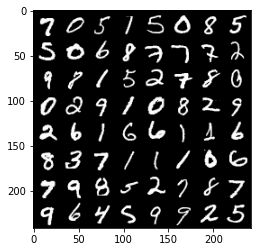

In [12]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## Как выглядит классификация с RNN в общем виде 

<img src="https://cdn-images-1.medium.com/max/1600/1*vhAfRLlaeOXZ-bruv7Ostg.png" width="400">

In [13]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super().__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        self.hidden = (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs)

In [14]:
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10

In [15]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[-0.0024, -0.1132, -0.1493, -0.0654, -0.0315, -0.0735,  0.0773, -0.0147,
         -0.0609,  0.0893],
        [ 0.0200, -0.0698, -0.1438, -0.0653, -0.0177, -0.0564,  0.0502, -0.0060,
         -0.0957,  0.0886],
        [ 0.0026, -0.0848, -0.1271, -0.0685, -0.0215, -0.0679,  0.0379, -0.0058,
         -0.0676,  0.1058],
        [ 0.0227, -0.0777, -0.1464, -0.0692, -0.0097, -0.0460,  0.0548, -0.0062,
         -0.0802,  0.0971],
        [ 0.0173, -0.0798, -0.1453, -0.0714, -0.0081, -0.0459,  0.0494, -0.0055,
         -0.0824,  0.0932],
        [ 0.0104, -0.0639, -0.1418, -0.0502, -0.0145, -0.0583,  0.0474,  0.0140,
         -0.0888,  0.0961],
        [ 0.0071, -0.0920, -0.1615, -0.0680, -0.0120, -0.0422,  0.0493, -0.0011,
         -0.0686,  0.0971],
        [ 0.0200, -0.0709, -0.1375, -0.0639, -0.0153, -0.0581,  0.0526, -0.0126,
         -0.0957,  0.0914],
        [ 0.0062, -0.0688, -0.1026, -0.0991, -0.0456, -0.0673,  0.0706, -0.0548,
         -0.0408,  0.1124],
        [ 0.0185, -

## Обучаем

In [16]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [17]:
for epoch in range(N_EPHOCS):
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.7121 | Train Accuracy: 76.96
Epoch:  1 | Loss: 0.2902 | Train Accuracy: 91.58
Epoch:  2 | Loss: 0.2254 | Train Accuracy: 93.51
Epoch:  3 | Loss: 0.1879 | Train Accuracy: 94.64
Epoch:  4 | Loss: 0.1601 | Train Accuracy: 95.50
Epoch:  5 | Loss: 0.1500 | Train Accuracy: 95.79
Epoch:  6 | Loss: 0.1341 | Train Accuracy: 96.25
Epoch:  7 | Loss: 0.1272 | Train Accuracy: 96.43
Epoch:  8 | Loss: 0.1156 | Train Accuracy: 96.74
Epoch:  9 | Loss: 0.1141 | Train Accuracy: 96.78


### Смотрим что на тесте

In [18]:
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 96.07


# Сентимент анализ

Домашка — классифицировать отзывы с IMDB на положительный / отрицательный только по тексту.

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment1.png">

Суть такая же, только нужно предобработать тексты — каждому слову сопоставить обучаемый вектор (embedding), который пойдёт дальше в RNN.

In [2]:
# это уберет боль работы с текстами
!pip install torchtext==0.8.1
!python -m spacy download en

     |████████████████████████████████| 12.0 MB 4.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


**Примечание.** Torchtext уже не очень живой проект, а в spacy нет русского.


In [27]:
import torch
from torchtext import data

SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(dtype=torch.float)

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: LabelField class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [4]:
from torchtext import datasets
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL, root="./data")

/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [5]:
ls -lh data/imdb/aclImdb/

total 1.7M
-rw-r--r-- 1 7297 1000 882K Jun 11  2011 imdbEr.txt
-rw-r--r-- 1 7297 1000 827K Apr 12  2011 imdb.vocab
-rw-r--r-- 1 7297 1000 4.0K Jun 26  2011 README
drwxr-xr-x 4 7297 1000 4.0K Apr 12  2011 test/
drwxr-xr-x 5 7297 1000 4.0K Jun 26  2011 train/


In [6]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [7]:
print(vars(train_data.examples[0]))

{'text': ['Another', 'outstanding', 'foreign', 'film', 'which', 'thoroughly', 'trounces', 'the', 'never', '-', 'ending', 'crop', 'of', 'crud', 'emanating', 'from', 'Hollywood', '!', 'This', 'is', 'a', 'story', 'of', 'life', 'and', 'living', '.', 'No', ',', 'definitely', 'not', 'the', 'perfect', 'little', 'life', 'so', 'often', 'depicted', 'in', 'the', 'totally', 'artificial', 'Hollywood', 'movies', 'but', 'rather', ',', 'the', 'real', 'life', 'complete', 'with', 'real', 'characters', 'each', 'with', 'strengths', 'and', 'weaknesses', 'just', 'like', 'real', 'people', 'in', 'our', 'lives', 'and', 'ourselves.<br', '/><br', '/>The', 'dynamics', 'of', 'all', 'of', 'these', 'lives', ',', 'intertwined', 'within', 'the', 'walls', 'of', 'this', 'bathhouse', ',', 'and', 'particularly', 'its', 'aged', 'owner', ',', 'are', 'magnificent', ',', 'heart', 'touching', 'and', 'highly', 'thought', 'provoking.<br', '/><br', '/>Sit', 'back', ',', 'relax', ',', 'and', 'be', 'carried', 'away', 'into', 'the',

In [8]:
# Сделаем еще eval
import random

train_data, valid_data = train_data.split(random_state=random.seed(SEED))

In [9]:
# Сделаем словарь
TEXT.build_vocab(train_data, max_size=25000)
LABEL.build_vocab(train_data)

In [10]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [11]:
vars(LABEL.vocab)

{'freqs': Counter({'neg': 8810, 'pos': 8690}),
 'itos': ['neg', 'pos'],
 'stoi': defaultdict(None, {'neg': 0, 'pos': 1}),
 'unk_index': None,
 'vectors': None}

Почему 25002, а не 25000?
Потому что $<unk>$ и $<pad>$

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment6.png" width="160">

In [12]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 202128), (',', 192016), ('.', 165724), ('and', 109545), ('a', 109401), ('of', 100656), ('to', 93573), ('is', 76262), ('in', 61398), ('I', 54380), ('it', 53455), ('that', 49455), ('"', 44276), ("'s", 43511), ('this', 42530), ('-', 36664), ('was', 35301), ('/><br', 35242), ('as', 30498), ('with', 29978)]


* stoi (string to int)
* itos (int to string)

In [13]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']


In [14]:
print(LABEL.vocab.stoi)

defaultdict(None, {'neg': 0, 'pos': 1})


In [15]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# собираем батчи так, чтобы в каждом батче были примеры наиболее похожей длины
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    device=device)

/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


## Делаем модель

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment7.png" width="450">

* В эмбеддер (emb = [torch.nn.Embedding(num_embeddings, embedding_dim)](https://pytorch.org/docs/stable/nn.html?highlight=embedding#torch.nn.Embedding)) запихиваем тензор размерностью **[sentence length, batch size]**
* Эмбеддер возвращает тензор размерностью **[sentence length, batch size, embedding dim]**
* RNN (torch.nn.RNN(embedding_dim, hidden_dim)) возвращает 2 тензора, *output* размера [sentence length, batch size, hidden dim] и *hidden* размера [1, batch size, hidden dim]

# Vanila

In [16]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

        #text,shape = [sent len, batch size]
        
    def forward(self, x):
        embedded = embedded = self.embedding(x)
        
        #embedded.shape = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        
        #output.shape = [sent len, batch size, hid dim]
        #hidden.shape = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))

In [17]:
len(TEXT.vocab)

25002

In [18]:
EMBEDDING_DIM = 128
INPUT_DIM = 25002
HIDDEN_DIM = 256
OUTPUT_DIM = 1
EPOCHS = 10
LR = 1e-4

In [22]:
model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss()

In [23]:
def accuracy(true, pred):
    correct = ((torch.sigmoid(pred) > 0.5) == true).sum()

    return correct / len(true)

In [24]:
history = []

for epoch in range(EPOCHS):
    history_accuracy = []

    for idx, data in enumerate(train_iterator):
        x = data.text
        y = data.label

        optimizer.zero_grad()
        preds = model(x)
        preds = preds.view(-1)

        loss = criterion(preds, y)

        loss.backward()
        optimizer.step()

        history.append(loss.item())
        history_accuracy.append(accuracy(y, preds))

    print(f'EPOCH: {epoch + 1} | Accuracy: {sum(history_accuracy) / len(train_iterator)}')


/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


EPOCH: 1 | Accuracy: 0.5056291818618774
EPOCH: 2 | Accuracy: 0.49767008423805237
EPOCH: 3 | Accuracy: 0.5088470578193665
EPOCH: 4 | Accuracy: 0.5006680488586426
EPOCH: 5 | Accuracy: 0.4978167712688446
EPOCH: 6 | Accuracy: 0.5033400654792786
EPOCH: 7 | Accuracy: 0.5037555694580078
EPOCH: 8 | Accuracy: 0.5034459829330444
EPOCH: 9 | Accuracy: 0.5068838000297546
EPOCH: 10 | Accuracy: 0.4995112121105194


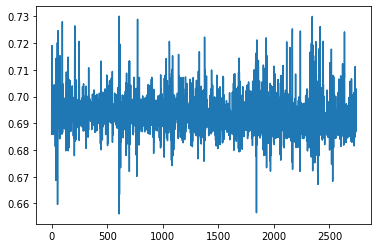

In [31]:
import matplotlib.pyplot as plt

plt.plot(history)

## LSTM

In [35]:
class LSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

        #text,shape = [sent len, batch size]
        
    def forward(self, x, length):
        embedded = embedded = self.embedding(x)
        
        #embedded.shape = [sent len, batch size, emb dim]
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, length)
        output, (hidden, cell) = self.lstm(embedded)
        
        return self.fc(hidden.squeeze(0))

Попробуем лстм с предобученным Glove

In [28]:
TEXT = data.Field(tokenize='spacy', include_lengths=True)
LABEL = data.LabelField(dtype=torch.float)
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
train_data, valid_data = train_data.split(random_state=random.seed(SEED), split_ratio=0.8)

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: LabelField class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:08<00:00, 9.99MB/s]
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [32]:
TEXT.build_vocab(train_data,
                 max_size=25000,
                 vectors='glove.6B.100d',
                 unk_init=torch.Tensor.normal_)
LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [02:42, 5.29MB/s]                           
100%|█████████▉| 399999/400000 [00:23<00:00, 16762.32it/s]


In [33]:
print(f'Vocabulary size: {len(TEXT.vocab)}')
print(f'Number of classes: {len(LABEL.vocab)}')

Vocabulary size: 25002
Number of classes: 2


In [34]:
train_loader, valid_loader, test_loader = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    sort_within_batch=True,
    device=device)

/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [36]:
model = LSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss()

In [39]:
history = []

for epoch in range(EPOCHS):
    history_accuracy = []

    for idx, data in enumerate(train_loader):
        x, length = data.text
        y = data.label

        optimizer.zero_grad()
        preds = model(x, length.cpu().int())
        preds = preds.view(-1)

        loss = criterion(preds, y)

        loss.backward()
        optimizer.step()

        history.append(loss.item())
        history_accuracy.append(accuracy(y, preds))

    print(f'EPOCH: {epoch + 1} | Accuracy: {sum(history_accuracy) / len(train_iterator)}')


/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


EPOCH: 1 | Accuracy: 0.5970004796981812
EPOCH: 2 | Accuracy: 0.6924611926078796
EPOCH: 3 | Accuracy: 0.7760606408119202
EPOCH: 4 | Accuracy: 0.8099908828735352
EPOCH: 5 | Accuracy: 0.8629676103591919
EPOCH: 6 | Accuracy: 0.8940465450286865
EPOCH: 7 | Accuracy: 0.9141765236854553
EPOCH: 8 | Accuracy: 0.9357892274856567
EPOCH: 9 | Accuracy: 0.9475935101509094
EPOCH: 10 | Accuracy: 0.9425182342529297


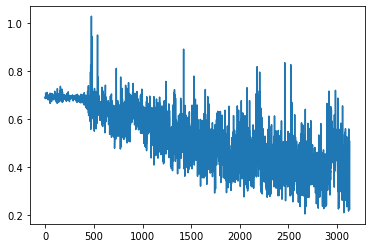

In [40]:
plt.plot(history)